In [251]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import os

In [252]:
os.chdir("/home/vladimir/conda")

In [253]:
df = pd.read_csv("Econom_Cities_data.csv", sep=";",index_col="City",decimal=",")

In [254]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
df[:]

,Work,Price,Salary
City,,,
Amsterdam,1714,65.6,49.0
Athens,1792,53.8,30.4
Bogota,2152,37.9,11.5
Bombay,2052,30.3,5.3
Brussels,1708,73.8,50.5
Buenos_Aires,1971,56.1,12.5
Cairo,-9999,37.1,-9999.0
Caracas,2041,61.0,10.9
Chicago,1924,73.9,61.9


Как видим, у Каира и Джакарты значения двух полей равны $-9999$. Это выбросы, очевидно, удалим их.

In [255]:
df=df.drop(index=["Cairo","Jakarta"])

Также заметим, что если мы хотим использовать евклидову метрику, то переменная Work будет иметь определяющий вклад. Возьмём значение в Цюрихе за $100$ % и будем использовать проценты, как и в других столбцах.

In [256]:
df["Work"]=df["Work"]/1868*100

In [257]:
from sklearn.cluster import KMeans

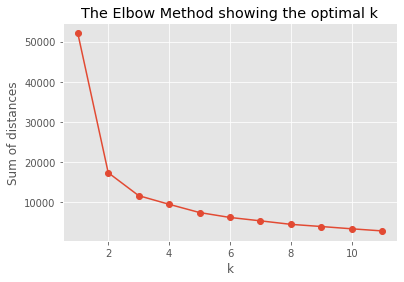

In [258]:
K = range(1, 12)
models = [KMeans(n_clusters=k, random_state=4).fit(df) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

 Как видим, начиная с трёх, скорость убывания графика заметно снижается. Попробуем взять четыре -- оптимальный выбор.

In [259]:
model = KMeans(n_clusters=4, random_state=22, init='k-means++')
model.fit(df)
df['cluster'] = model.labels_
df.groupby('cluster').mean()

,Work,Price,Salary
cluster,,,
0,104.871520,57.990,22.850
1,96.876338,77.865,54.125
2,95.315846,108.550,71.300
3,107.119914,43.610,8.030


In [260]:
df.groupby('cluster').size()

cluster
0    10
1    20
2     6
3    10
dtype: int64

In [261]:
df[df['cluster']==3]

,Work,Price,Salary,cluster
City,,,,
Bogota,115.203426,37.9,11.5,3
Bombay,109.850107,30.3,5.3,3
Kuala_Lumpur,116.006424,43.5,9.9,3
Lagos,95.610278,45.2,2.7,3
Manila,121.413276,40.0,4.0,3
Mexico_City,104.068522,49.8,5.7,3
Nairobi,104.817987,45.0,5.8,3
Panama,111.241970,49.2,13.8,3
Rio_de_Janeiro,93.629550,46.3,10.5,3


Кластер №0 - "развивающиеся". Много работают, цены - средние, зарплаты - маленькие. В кластер входят крупные города развивающихся азиатских стран, стран латинской Америки и отстающие европейские столицы - Афины, Никосия и Лиссабон. 

Кластер №1 - "средняки". Зарплаты в несколько раз выше, чем у "бедняков". Цены также выше в 1,5 раза. Крупные европейские и североамериканские города (+Сидней).

Кластер №2 - "богачи". Работают не больше, чем нужно, цены - высокие (дорогая недвижимость?), заплаты - солидные (хотя Стокгольм несколько выбивается). Европейские города с наибольшим уровнем жизни (+Токио).

Кластер №4 - "за чертой бедности". Много работают, цены - ниже средних, зарплаты - очень маленькие. В кластер входят отстающие города латинской Америки, африканские и азиатские города.

In [269]:
new_items = [
    [110,110,110],[100,100,20],[100,50,20],[120,10,10]
]
model.predict(new_items)

array([2, 1, 0, 3], dtype=int32)

Посмотрим, куда попадут города с заявленными показателями. Первый элемент - во второй кластер (логично, там же Цюрих), второй - в средняки (видимо из-за европейских цен), 3-ий - в развивающиеся (средние цены и низкая заплата), последний - в крайне бедные (очень низкая зарплата)